<a href="https://colab.research.google.com/github/SamerKharboush/GAN/blob/main/tensor-sk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN model using TensorFlow to generate synthetic tabular data for the given dataset.

First, let's import the necessary libraries and load the dataset.

In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers


warnings.filterwarnings("ignore")


In [ ]:
df_true = pd.read_csv("/content/train.csv").replace('?',np.nan).dropna()
print(df_true.shape)
df_true.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


This section drops the "id" column from the dataframe "df_true".

In [ ]:
# Remove ID column
df_true.drop('id', axis=1, inplace=True)


This section one-hot encodes the categorical variables "Gender", "Vehicle_Age", and "Vehicle_Damage" in the "df_true" dataframe.

In [ ]:
# One-hot encode categorical variables
df_true = pd.get_dummies(df_true, columns=['Gender', 'Vehicle_Age', 'Vehicle_Damage'])


This section normalizes the numerical variables "Age", "Region_Code", "Annual_Premium", and "Vintage" in the "df_true" dataframe.

In [ ]:
# Normalize numerical variables
cols_to_normalize = ['Age', 'Region_Code', 'Annual_Premium', 'Vintage']
df_true[cols_to_normalize] = (df_true[cols_to_normalize] - df_true[cols_to_normalize].mean()) / df_true[cols_to_normalize].std()


This section converts the "df_true" dataframe to a numpy array of type float32 and assigns it to the "data_true" variable.

In [ ]:
# Convert dataset to numpy array
data_true = df_true.values.astype(np.float32)


This section defines the generator model using Keras API. 

In [ ]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(100,), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1024, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(data_true.shape[1], activation='tanh'))

    return model


Define the discriminator model
This section defines a function called make_discriminator_model() 

In [ ]:

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1024, input_shape=(data_true.shape[1],)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1))

    return model

Define the loss functions


Define the optimizers


In [ ]:
# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


evaluation metrics

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import ks_2samp
def evaluate_accuracy(df_true, df_fake):

    # Check for NaN values and remove them
    df_true = df_true.dropna()
    df_fake = df_fake.dropna()

    # Calculate mean squared error
    mse = mean_squared_error(df_true, df_fake)

    # Calculate correlation
    corr = np.corrcoef(df_true.values.flatten(), df_fake.values.flatten())[0, 1]

    # Calculate Kolmogorov-Smirnov distance
    ks_dist = ks_2samp(df_true.values.flatten(), df_fake.values.flatten())[0]

    # Calculate the percentage of accuracy
    accuracy = (1 - (abs(df_fake - df_true) / df_true).mean()) * 100

    return {"MSE": mse, "Correlation": corr, "KS distance": ks_dist, "Accuracy": accuracy}



Define the number of epochs and batch size

In [ ]:

EPOCHS = 50
BATCH_SIZE = 256

Define the number of latent dimensions


In [ ]:
noise_dim = 100
latent_dim = 100

 Instantiate the generator and discriminator models


In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

Define the optimizer


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training loop

In [ ]:

@tf.function
def train_step(data_true):
    # Generate noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Gradient tape to record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake data using the generator
        data_fake = generator(noise, training=True)

        # Get the discriminator's predictions for the real and fake data
        real_output = discriminator(data_true, training=True)
        fake_output = discriminator(data_fake, training=True)

        # Calculate the loss for the generator and discriminator
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate the gradients of the generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to the optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


# Generate data

In [ ]:
def generate_data(n_samples):
    # Generate noise
    z = tf.random.normal((n_samples, latent_dim))
    # Generate synthetic data
    data_fake = generator(z, training=False)
    # Normalize columns
    data_fake = (data_fake - tf.math.reduce_mean(data_fake, axis=0)) / tf.math.reduce_std(data_fake, axis=0)
    # Denormalize columns
    data_fake = data_fake * df_true.std() + df_true.mean()
    # Convert to dataframe
    df_fake = pd.DataFrame(data_fake.numpy(), columns=df_true.columns)
    return df_fake

# EPOCHS


In [ ]:
# Generate and evaluate synthetic data every 10 epochs
for epoch in range(EPOCHS):
    # Shuffle the data
    np.random.shuffle(data_true)

    # Split the data into batches
    for i in range(0, data_true.shape[0], BATCH_SIZE):
        data_batch = data_true[i:i+BATCH_SIZE]

        # Train the discriminator
        train_step(data_batch)

    if epoch % 10 == 0:
        # Generate synthetic data
        df_fake = generate_data(data_true.shape[0])
        
        # Evaluate the accuracy of the synthetic data
        accuracy = evaluate_accuracy(df_true, df_fake)
        print(f"Epoch {epoch}: Accuracy = {accuracy}")



Epoch 0: Accuracy = {'MSE': 392.55436739131227, 'Correlation': 0.7981527542926853, 'KS distance': 0.20935760285552601, 'Accuracy': Age                      -15.344763
Driving_License                -inf
Region_Code              -81.644835
Previously_Insured             -inf
Annual_Premium           107.947334
Policy_Sales_Channel     -72.567919
Vintage                  130.863087
Response                       -inf
Gender_Female                  -inf
Gender_Male                    -inf
Vehicle_Age_1-2 Year           -inf
Vehicle_Age_< 1 Year           -inf
Vehicle_Age_> 2 Years          -inf
Vehicle_Damage_No              -inf
Vehicle_Damage_Yes             -inf
dtype: float64}
Epoch 10: Accuracy = {'MSE': 393.21516232201697, 'Correlation': 0.7978329591317547, 'KS distance': 0.2015094544255493, 'Accuracy': Age                      -14.685200
Driving_License                -inf
Region_Code             -137.872811
Previously_Insured             -inf
Annual_Premium            96.802507
Po

# Final accuracy


In [ ]:
# Evaluate the accuracy of the final synthetic data
df_fake = generate_data(data_true.shape[0])
accuracy = evaluate_accuracy(df_true, df_fake)
print(f"Final Accuracy = {accuracy}")


Final Accuracy = {'MSE': 392.7353720367244, 'Correlation': 0.7808339510071931, 'KS distance': 0.22696743801204722, 'Accuracy': Age                      -23.482772
Driving_License                -inf
Region_Code              -81.562040
Previously_Insured             -inf
Annual_Premium           197.624569
Policy_Sales_Channel     -64.701854
Vintage                  157.040570
Response                       -inf
Gender_Female                  -inf
Gender_Male                    -inf
Vehicle_Age_1-2 Year           -inf
Vehicle_Age_< 1 Year           -inf
Vehicle_Age_> 2 Years          -inf
Vehicle_Damage_No              -inf
Vehicle_Damage_Yes             -inf
dtype: float64}


In [ ]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Age                    381109 non-null  float32
 1   Driving_License        381109 non-null  float32
 2   Region_Code            381109 non-null  float32
 3   Previously_Insured     381109 non-null  float32
 4   Annual_Premium         381109 non-null  float32
 5   Policy_Sales_Channel   381109 non-null  float32
 6   Vintage                381109 non-null  float32
 7   Response               381109 non-null  float32
 8   Gender_Female          381109 non-null  float32
 9   Gender_Male            381109 non-null  float32
 10  Vehicle_Age_1-2 Year   381109 non-null  float32
 11  Vehicle_Age_< 1 Year   381109 non-null  float32
 12  Vehicle_Age_> 2 Years  381109 non-null  float32
 13  Vehicle_Damage_No      381109 non-null  float32
 14  Vehicle_Damage_Yes     381109 non-nu

In [ ]:
df_fake.to_csv('/content/df_fake.csv', index= True)

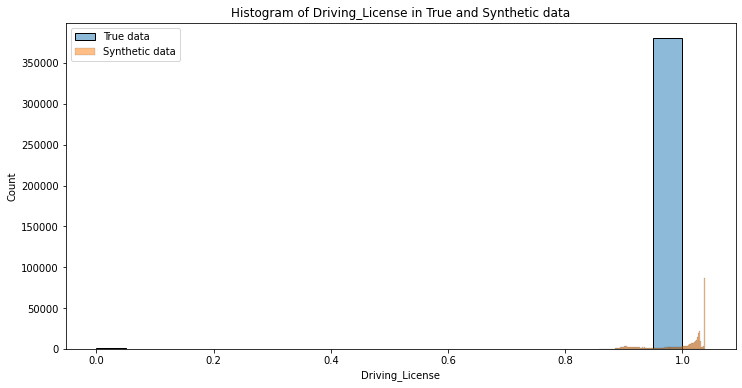

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Histograms
sns.histplot(data=df_true, x="Driving_License", label="True data", alpha=0.5)
sns.histplot(data=df_fake, x="Driving_License", label="Synthetic data", alpha=0.5)
plt.legend()
plt.title("Histogram of Driving_License in True and Synthetic data")
plt.show()


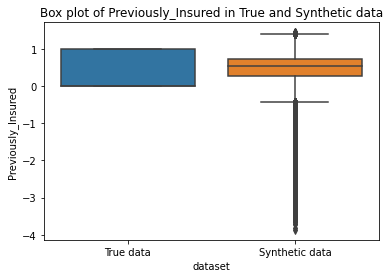

In [ ]:

# Box plots
sns.boxplot(data=pd.concat([df_true.assign(dataset="True data"), df_fake.assign(dataset="Synthetic data")]), x="dataset", y="Previously_Insured")
plt.title("Box plot of Previously_Insured in True and Synthetic data")
plt.show()



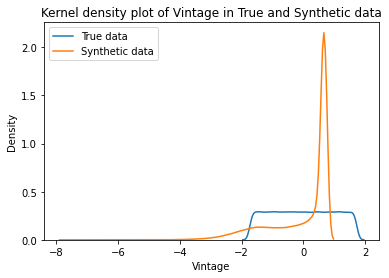

In [ ]:
# Kernel density plots
sns.kdeplot(data=df_true, x="Vintage", label="True data")
sns.kdeplot(data=df_fake, x="Vintage", label="Synthetic data")
plt.legend()
plt.title("Kernel density plot of Vintage in True and Synthetic data")
plt.show()



In [ ]:
 jupyter nbconvert --to pdf notebook.ipynb

SyntaxError: invalid syntax (1673223192.py, line 1)